# Lab04 - MLP + RF + GB


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from dslabs_functions import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pandas import read_csv, DataFrame

filename = "data/CFD_smote.csv"
target = "CLASS"
file_tag = "CFD"
file = "CFD"
data: DataFrame = read_csv(filename, na_values="")

train_filename = "data/CFD_train.csv"
test_filename = "data/CFD_test.csv"

eval_metric = "accuracy"

data.shape

(7072, 87)

Labels=[0, 1]


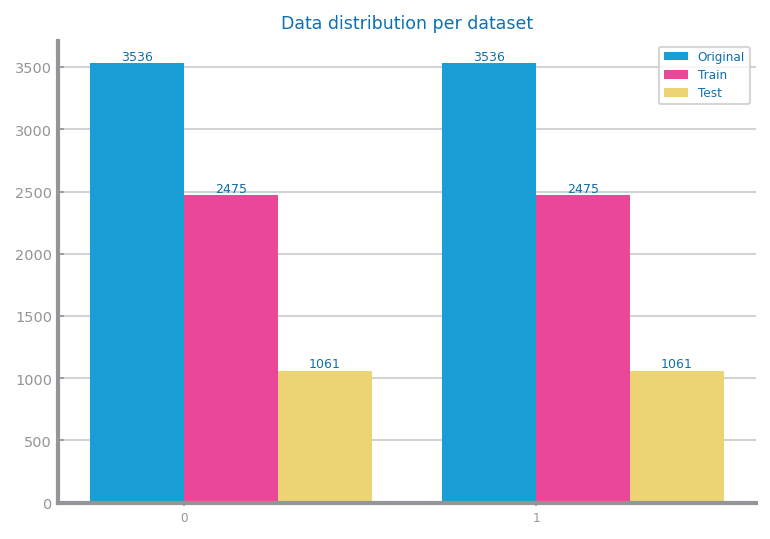

In [3]:
from numpy import array, ndarray
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart
from pandas import concat

# Identificar as labels (classes) do target
labels: list = list(data[target].unique())
labels.sort()
print(f"Labels={labels}")

positive: int = 1
negative: int = 0

# Verificar a distribuição inicial
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == negative]),
        len(data[data[target] == positive]),
    ]
}

# Separar X (features) e y (target)
y: array = data.pop(target).to_list()  # Remove o target do dataset
X: ndarray = data.values  # Obtém os valores das features como um ndarray

# Dividir os dados em treino e teste (antes de aplicar MinMaxScaler)
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# Aplicar MinMaxScaler (apenas aos dados de treino e teste separadamente)
scaler = MinMaxScaler(feature_range=(0, 1))
trnX_scaled = scaler.fit_transform(trnX)  # Ajustar e transformar os dados de treino
tstX_scaled = scaler.transform(tstX)      # Apenas transformar os dados de teste

# Reconstruir os DataFrames de treino e teste, incluindo o target
train: DataFrame = concat(
    [DataFrame(trnX_scaled, columns=data.columns), DataFrame(trnY, columns=[target])],
    axis=1,
)
train.to_csv(f"data/{file_tag}_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX_scaled, columns=data.columns), DataFrame(tstY, columns=[target])],
    axis=1,
)
test.to_csv(f"data/{file_tag}_test.csv", index=False)

# Atualizar a distribuição de classes nos conjuntos de treino e teste
values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

# Plotar a distribuição de classes
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()


## Auxiliar functions

In [ ]:
def process_and_study_model(model, study_function):
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
        train_filename, test_filename, target
    )

    if 'Financial Distress' in vars:
        col_idx = vars.index('Financial Distress')
        trnX = np.delete(trnX, col_idx, axis=1)
        tstX = np.delete(tstX, col_idx, axis=1)
        vars.pop(col_idx)

    print(f"Train#={len(trnX)} Test#={len(tstX)}")
    print(f"Labels={labels}")

    figure()
    best_model, params = study_function(
        trnX,
        trnY,
        tstX,
        tstY,
        nr_max_iterations=5000,
        lag=500,
        metric=eval_metric,
        model=model,
    )
    savefig(f"images/{file_tag}_{model}_{eval_metric}_study.png")
    show()

    return best_model, params

def evaluate_and_plot_model(best_model, params):
    prd_trn = best_model.predict(trnX)
    prd_tst = best_model.predict(tstX)

    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_{params["model"]}_{params["name"]}_best_{params["metric"]}_eval.png')
    show()


## Train Test Split

In [4]:
# from numpy import array, ndarray
# from pandas import read_csv, DataFrame

# labels: list = list(data[target].unique())
# labels.sort()
# print(f"Labels={labels}")

# positive: int = 1
# negative: int = 0
# values: dict[str, list[int]] = {
#     "Original": [
#         len(data[data[target] == negative]),
#         len(data[data[target] == positive]),
#     ]
# }

# y: array = data.pop(target).to_list()
# X: ndarray = data.values

## Balancing data

In [5]:
# from pandas import concat
# from matplotlib.pyplot import figure, show
# from sklearn.model_selection import train_test_split
# from dslabs_functions import plot_multibar_chart


# trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

# train: DataFrame = concat(
#     [DataFrame(trnX, columns=data.columns), DataFrame(trnY, columns=[target])], axis=1
# )
# train.to_csv(f"data/{file_tag}_train.csv", index=False)

# test: DataFrame = concat(
#     [DataFrame(tstX, columns=data.columns), DataFrame(tstY, columns=[target])], axis=1
# )
# test.to_csv(f"data/{file_tag}_test.csv", index=False)

# values["Train"] = [
#     len(train[train[target] == negative]),
#     len(train[train[target] == positive]),
# ]
# values["Test"] = [
#     len(test[test[target] == negative]),
#     len(test[test[target] == positive]),
# ]

# figure(figsize=(6, 4))
# plot_multibar_chart(labels, values, title="Data distribution per dataset")
# show()

## Multi Layer Perceptrons

In [ ]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.neural_network import MLPClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart

LAG: int = 500
NR_MAX_ITER: int = 5000

def mlp_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[MLPClassifier | None, dict]:
    nr_iterations: list[int] = [lag] + [
        i for i in range(2 * lag, nr_max_iterations + 1, lag)
    ]

    lr_types: list[Literal["constant", "invscaling", "adaptive"]] = [
        "constant",
        "invscaling",
        "adaptive",
    ]  # only used if optimizer='sgd'
    learning_rates: list[float] = [0.5, 0.05, 0.005, 0.0005]

    best_model: MLPClassifier | None = None
    best_params: dict = {"name": "MLP", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    _, axs = subplots(
        1, len(lr_types), figsize=(len(lr_types) * HEIGHT, HEIGHT), squeeze=False
    )
    for i in range(len(lr_types)):
        type: str = lr_types[i]
        values = {}
        for lr in learning_rates:
            warm_start: bool = False
            y_tst_values: list[float] = []
            for j in range(len(nr_iterations)):
                clf = MLPClassifier(
                    learning_rate=type,
                    learning_rate_init=lr,
                    max_iter=lag,
                    warm_start=warm_start,
                    activation="logistic",
                    solver="sgd",
                    verbose=False,
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                warm_start = True
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (type, lr, nr_iterations[j])
                    best_model = clf
                # print(f'MLP lr_type={type} lr={lr} n={nr_iterations[j]}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            nr_iterations,
            values,
            ax=axs[0, i],
            title=f"MLP with {type}",
            xlabel="nr iterations",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'MLP best for {best_params["params"][2]} iterations (lr_type={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

# Drop the column 'Financial Distress' from both train and test feature sets
if 'Financial Distress' in vars:
    col_idx = vars.index('Financial Distress')  # Get the column index
    trnX = np.delete(trnX, col_idx, axis=1)     # Drop from train set
    tstX = np.delete(tstX, col_idx, axis=1)     # Drop from test set
    vars.pop(col_idx)                           # Remove column name from the list
    print("Dropped column: 'Financial Distress'")

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = mlp_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=NR_MAX_ITER,
    lag=LAG,
    metric=eval_metric,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_study.png")
show()

Dropped column: 'Financial Distress'
Train#=4950 Test#=2122
Labels=[0, 1]


### Best model performance

In [ ]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_mlp_{params["name"]}_best_{params["metric"]}_eval.png')
show()

### Overfitting study


In [ ]:
lr_type: Literal["constant", "invscaling", "adaptive"] = params["params"][0]
lr: float = params["params"][1]

nr_iterations: list[int] = [LAG] + [i for i in range(2 * LAG, NR_MAX_ITER + 1, LAG)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = MLPClassifier(
        warm_start=warm_start,
        learning_rate=lr_type,
        learning_rate_init=lr,
        max_iter=n,
        activation="logistic",
        solver="sgd",
        verbose=False,
    )
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"MLP overfitting study for lr_type={lr_type} and lr={lr}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_overfitting.png")

### Loss Curve

In [ ]:
from numpy import arange
from dslabs_functions import plot_line_chart


figure()
plot_line_chart(
    arange(len(best_model.loss_curve_)),
    best_model.loss_curve_,
    title="Loss curve for MLP best model training",
    xlabel="iterations",
    ylabel="loss",
    percentage=False,
)
savefig(f"images/{file_tag}_mlp_{eval_metric}_loss_curve.png")

## Support Vector Machines

In [ ]:
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.svm import SVC
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import plot_evaluation_results, plot_multiline_chart


def svm_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_iterations: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[SVC | None, dict]:
    nr_iterations: list[int] = [100] + [
        i for i in range(500, nr_max_iterations + 1, lag)
    ]

    kernel_types: list[str] = ["linear", "poly", "rbf", "sigmoid"]
    poly_degrees: list[int] = [2, 3, 4]

    best_model = None
    best_params: dict = {"name": "SVM", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    for kernel in kernel_types:
        degrees: list[int] = poly_degrees if "poly" == kernel else [0]
        for d in degrees:
            kernel_name: str = f"poly_{d}" if "poly" == kernel else kernel
            y_tst_values: list[float] = []
            for n in nr_iterations:
                clf = SVC(kernel=kernel, max_iter=n, degree=d, verbose=False)
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (kernel, n, d)
                    best_model = clf
                # print(f'SVM lr_type={kernel_name} n={n} -> {eval}')
            values[kernel_name] = y_tst_values
    plot_multiline_chart(
        nr_iterations,
        values,
        title=f"SVM models ({metric})",
        xlabel="nr iterations",
        ylabel=metric,
        percentage=True,
    )
    best_kernel = best_params["params"][0]
    kernel_name = (
        f'poly_{best_params["params"][2]}' if "poly" == best_kernel else best_kernel
    )
    print(f'SVM best for {kernel_name} and n={best_params["params"][1]}')

    return best_model, best_params

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)

# Drop the column 'Financial Distress' from both train and test feature sets
if 'Financial Distress' in vars:
    col_idx = vars.index('Financial Distress')  # Get the column index
    trnX = np.delete(trnX, col_idx, axis=1)     # Drop from train set
    tstX = np.delete(tstX, col_idx, axis=1)     # Drop from test set
    vars.pop(col_idx)                           # Remove column name from the list

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_model, params = svm_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_iterations=5000,
    lag=500,
    metric=eval_metric,
)
savefig(f"images/{file_tag}_svm_{eval_metric}_study.png")
show()

### Best model performance

In [ ]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_svm_{params["name"]}_best_{params["metric"]}_eval.png')
show()

### Variables relevancy - I am not sure if this is the right stuff

In [ ]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_rf_{eval_metric}_best_tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

### Overfitting study


In [ ]:
kernel: str = params["params"][0]
degree: int = params["params"][2]
kernel_name: str = f'poly (d={params["params"][2]})' if "poly" == kernel else kernel
nr_iterations: list[int] = [100] + [i for i in range(500, 5001, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

warm_start: bool = False
for n in nr_iterations:
    clf = SVC(kernel=kernel, max_iter=n, degree=degree, verbose=False)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))
    warm_start = True

figure()
plot_multiline_chart(
    nr_iterations,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"SVM overfitting study for {kernel_name}",
    xlabel="nr_iterations",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_svm_{eval_metric}_overfitting.png")

## Random Forest

In [ ]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import RandomForestClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def random_forests_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[RandomForestClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    max_features: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: RandomForestClassifier | None = None
    best_params: dict = {"name": "RF", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}

    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for f in max_features:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = RandomForestClassifier(
                    n_estimators=n, max_depth=d, max_features=f
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, f, n)
                    best_model = clf
                # print(f'RF d={d} f={f} n={n}')
            values[f] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Random Forests with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'RF best for {best_params["params"][2]} trees (d={best_params["params"][0]} and f={best_params["params"][1]})'
    )
    return best_model, best_params


### Process and Study

In [ ]:

best_model, params = process_and_study_model("rf", random_forests_study)

### Best model performance

In [ ]:

evaluate_and_plot_model(best_model, params)

### Variables relevancy

In [ ]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
)
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_vars_ranking.png")

### Overfitting study

In [ ]:
d_max: int = params["params"][0]
feat: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

## Gradient Boosting

In [ ]:
from numpy import array, ndarray
from matplotlib.pyplot import subplots, figure, savefig, show
from sklearn.ensemble import GradientBoostingClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"Gradient Boosting with max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'GB best for {best_params["params"][2]} trees (d={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

### Process and Study

In [ ]:
best_model, params = process_and_study_model("gb", gradient_boosting_study)

### Best model performance

In [ ]:
evaluate_and_plot_model(best_model, params)

### Variables relevancy

In [ ]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_vars_ranking.png")

### Overfitting study

In [ ]:
d_max: int = params["params"][0]
lr: float = params["params"][1]
nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric: str = "accuracy"

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")